# Steered MD analysis

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import nglview as ng
from IPython.display import display
import pytraj as pt

In [2]:
import yaml
with open('../.defaults/config', 'r') as file:
    _settings = yaml.load(file, Loader=yaml.FullLoader)

## Load data

Select data:

In [3]:
system = widgets.Dropdown(options=os.listdir('/home/adele/Documents/EPAC1/systems'), description='System:')
display(system)
state = widgets.RadioButtons(options=os.listdir(f'/home/adele/Documents/EPAC1/systems/{system.value}'), description='State:')
display(state)
folder = widgets.Text(description='Folder:')
display(folder)

Dropdown(description='System:', options=('cAMP', 'nohup.out', 'apo', 'I942', 'L273W'), value='cAMP')

RadioButtons(description='State:', options=('inactive', 'rename.sh', 'active'), value='inactive')

Text(value='', description='Folder:')

Go to folder:

In [24]:
if folder.value == '':
    folder_name = 'seeded-md'
elif 'seeded-md' in folder.value:
    folder_name = folder.value
else:
    folder_name = f'seeded-md_{folder.value}'
os.chdir(f'/home/adele/Documents/EPAC1/systems/{system.value}/{state.value}/{folder_name}/steering')

Load PLUMED output:

In [25]:
data1 = pd.read_csv('steering_1.dat', delim_whitespace=True)
columns = data1.columns[2:]
data1 = data1.iloc[:,:-2]
data1.columns = columns
data1.index = data1['time']/1000

In [26]:
data2 = pd.read_csv('steering_2.dat', delim_whitespace=True)
columns = data2.columns[2:]
data2 = data2.iloc[:,:-2]
data2.columns = columns
data2.index = data2['time']/1000

In [27]:
data = pd.concat([data1.iloc[1:12002], data2], ignore_index=True)
data['time'] = data.index*0.005
data.index = data['time']

## Plot data

This section is for plotting the CV outputs to check whether the sMD simulation was successful. It is recommended to set up any additional analysis here and run this notebook to check each sMD trajectory.

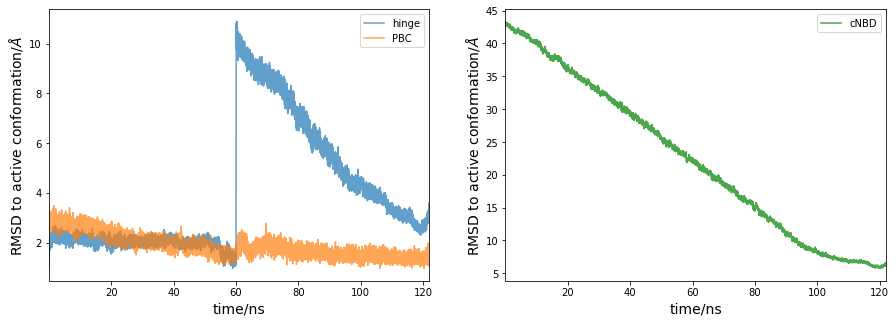

In [28]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(data.index[1:], data.iloc[1:,1]*10, alpha=0.7, label='hinge')
ax[0].plot(data.index[1:], data.iloc[1:,2]*10, alpha=0.7, label='PBC')
ax[1].plot(data.index[1:], data.iloc[1:,3]*10, alpha=0.7, label='cNBD', color='green')

references = ['active', 'active']


for i in range(2):
    ax[i].legend()
    ax[i].set_xlim(data.index[1], data.index[-1])
    ax[i].set_xlabel('time/ns', size=14)
    ax[i].set_ylabel(f'RMSD to {references[i]} conformation/$\AA$', size=14)

#ax[0].set_xlim(0, 1)

## Sample trajectory

Select snapshot number and set steering duration:

In [29]:
snapshot_number = widgets.IntText(value=100)
traj_duration = widgets.IntText(value=data.index.max()//10*10)
display(widgets.HBox([widgets.Label('Snapshot number:'), snapshot_number]))
display(widgets.HBox([widgets.Label('Trajectory duration/ns:'), traj_duration]))

In [30]:
last_frame = int(traj_duration.value/(data.index[2]-data.index[1]))
snapshot_idxs = np.linspace(0, last_frame, snapshot_number.value, dtype=int)

Check that the snapshots sample the conformational space well:

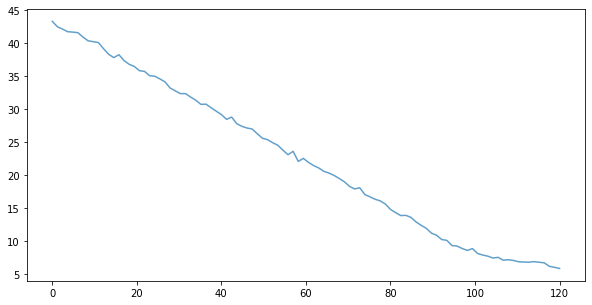

In [31]:
fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(data.iloc[snapshot_idxs].index, data.iloc[:,3].iloc[snapshot_idxs]*10, alpha=0.7, label='Hinge')

Visualize trajectory:

In [32]:
align_mask = ':122-263&!(@/H)'

In [33]:
reference = pt.load('reference_1_1.pdb')

In [34]:
trajectory = pt.load('steering_dry.nc', top='../../system-setup/system_dry.prm7')
trajectory = pt.align(trajectory, align_mask, ref=reference, ref_mask='*')

In [35]:
view = ng.show_pytraj(trajectory)
view.clear_representations()
view.add_representation('cartoon', color='gray')
view.add_representation('licorice', selection='I94 or 222 or 306')
view.add_representation('cartoon', selection='250-262 or 223-227', color='magenta')
view.add_component(reference)
view.component_1.clear_representations()
view.component_1.add_representation('cartoon', color='yellow')
view.display()

NGLWidget(max_frame=24399)

Save snapshots:

In [16]:
if not os.path.exists('../snapshots'):
    os.mkdir('../snapshots')

In [38]:
frame_idxs = []
for i, idx in enumerate(snapshot_idxs):
    if idx < 12000:
        snapshot = pt.load('steering_1.nc', top='../../system-setup/system.prm7', frame_indices=[idx])
    else:
        snapshot = pt.load('steering_2.nc', top='../../system-setup/system.prm7', frame_indices=[idx-12000])
    if not os.path.exists(f'../snapshots/snapshot_{i+1}.rst7'):
        pt.io.save_traj(f'../snapshots/snapshot_{i+1}.rst7', snapshot, format='rst7')
        os.rename(f'../snapshots/snapshot_{i+1}.rst7.1', f'../snapshots/snapshot_{i+1}.rst7')
    frame_idxs.append(f'{i+1} {idx}\n')

In [39]:
with open('../snapshots/snapshot_idxs.txt', 'w') as file:
    file.writelines(frame_idxs)